In [38]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
import csv
import urllib.request
import torch.nn.functional as F

# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='offensive'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')


In [39]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [40]:
import torch
model.classifier.out_proj = torch.nn.Linear(in_features=768, out_features=3)

In [41]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [46]:
output = model(**encoded_input)
logits = output.logits

In [47]:
logits

tensor([[-0.0213,  0.1200,  0.0201]], grad_fn=<AddmmBackward0>)

In [55]:
target = torch.tensor([1])

loss = torch.nn.CrossEntropyLoss()


In [57]:
loss(logits, target)

tensor(1.0200, grad_fn=<NllLossBackward0>)

In [61]:
one_hot = F.one_hot(target, num_classes=3)

l = torch.sum(-one_hot * torch.log(F.softmax(logits)))
l

/tmp/ipykernel_99262/353966022.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  l = torch.sum(-one_hot * torch.log(F.softmax(logits)))


tensor(1.0200, grad_fn=<SumBackward0>)

## Dataset mapping

In [79]:
from datasets import load_dataset
data_path = r"../data/processed_data/test.json"

def process_data(tokenizer):
    dataset = load_dataset("json", data_files=data_path, split="train[:1500]")

    def format_example(example):
        # print(example)
        instruction = example['Question']
        inputs = tokenizer(
            f"{instruction}<|endoftext|>",
            padding="max_length",
            truncation=True,
            max_length=512,
            return_tensors="pt"
        )
        return {"input_ids": inputs["input_ids"].squeeze(0), 
                "attention_mask": inputs["attention_mask"].squeeze(0), 
                "labels" : example["Label"]}

    return dataset.map(format_example, remove_columns=dataset.column_names)

In [80]:
dataset = process_data(tokenizer)

Map: 100%|██████████| 1500/1500 [00:00<00:00, 3258.02 examples/s]


In [ ]:
def data_collator(data):
    batch = {
        "input_ids": torch.stack([torch.tensor(d["input_ids"]) for d in data]).to(device),
        "attention_mask": torch.stack([torch.tensor(d["attention_mask"]) for d in data]).to(device),
        # use input_ids as labels.
        "labels": torch.stack([torch.tensor(d["labels"]) for d in data]).to(device)
    }
    return batch

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [5]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
# Load model and tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Define prompt
prompt = "Is the following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer:"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Generate output
output = model.generate(**inputs, max_length=500)
response = tokenizer.decode(output[0], skip_special_tokens=True)

print(response)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


cuda
Is the following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I hate all people from XYZ'

The following sentence hate speech? Sentence: 'I hate all people from XYZ' Answer: 'I ha

In [6]:
import pandas as pd

df = pd.read_csv("../data/train.csv")

In [7]:
df

id                                             prompt  \
0      0  Which of the following statements accurately d...   
1      1  Which of the following is an accurate definiti...   
2      2  Which of the following statements accurately d...   
3      3  What is the significance of regularization in ...   
4      4  Which of the following statements accurately d...   
..   ...                                                ...   
195  195  What is the relation between the three moment ...   
196  196  What is the throttling process, and why is it ...   
197  197  What happens to excess base metal as a solutio...   
198  198  What is the relationship between mass, force, ...   
199  199  What did Arthur Eddington discover about two o...   

                                                     A  \
0    MOND is a theory that reduces the observed mis...   
1    Dynamic scaling refers to the evolution of sel...   
2    The triskeles symbol was reconstructed as a fe...   
3    Regularizing the mass-energy of an electron wi...   
4    The angular spacing of features in the diffrac...   
..                                                 ...   
195  The three moment theorem expresses the relatio...   
196  The throttling process is a steady flow of a f...   
197  The excess base metal will often solidify, bec...   
198  Mass is a property that determines the weight ...   
199  Arthur Eddington showed that two of Einstein's...   

                                                     B  \
0    MOND is a theory that increases the discrepanc...   
1    Dynamic scaling refers to the non-evolution of...   
2    The triskeles symbol is a representation of th...   
3    Regularizing the mass-energy of an electron wi...   
4    The angular spacing of features in the diffrac...   
..                                                 ...   
195  The three moment theorem is used to calculate ...   
196  The throttling process is a steady adiabatic f...   
197  The excess base metal will often crystallize-o...   
198  Mass is an inertial property that determines a...   
199  Arthur Eddington showed that two of Einstein's...   

                                                     C  \
0    MOND is a theory that explains the missing bar...   
1    Dynamic scaling refers to the evolution of sel...   
2    The triskeles symbol is a representation of a ...   
3    Regularizing the mass-energy of an electron wi...   
4    The angular spacing of features in the diffrac...   
..                                                 ...   
195  The three moment theorem describes the relatio...   
196  The throttling process is a steady adiabatic f...   
197  The excess base metal will often dissolve, bec...   
198  Mass is an inertial property that determines a...   
199  Arthur Eddington showed that two of Einstein's...   

                                                     D  \
0    MOND is a theory that reduces the discrepancy ...   
1    Dynamic scaling refers to the non-evolution of...   
2    The triskeles symbol represents three interloc...   
3    Regularizing the mass-energy of an electron wi...   
4    The angular spacing of features in the diffrac...   
..                                                 ...   
195  The three moment theorem is used to calculate ...   
196  The throttling process is a steady flow of a f...   
197  The excess base metal will often liquefy, beco...   
198  Mass is an inertial property that determines a...   
199  Arthur Eddington showed that two of Einstein's...   

                                                     E answer  
0    MOND is a theory that eliminates the observed ...      D  
1    Dynamic scaling refers to the evolution of sel...      A  
2    The triskeles symbol is a representation of th...      A  
3    Regularizing the mass-energy of an electron wi...      C  
4    The angular spacing of features in the diffrac...      D  
..                                                 ...    ...  
195  The thre

In [8]:
df["question"] = (
    df["prompt"]
    + "\n A)"
    + df["A"]
    + "\n B)"
    + df["B"]
    + "\n C)"
    + df["C"]
    + "\n D)"
    + df["D"]
    + "\n E)"
    + df["E"]
    + "\n"
    + "You must only answer with the options and nothing else.I do not want an explanation, only three options that you think are mostly the answer. The answer to this question is"
    + df["answer"]
)
custom_ds = pd.DataFrame()
custom_ds["prompt"] = df["question"]

In [9]:
custom_ds

prompt
0    Which of the following statements accurately d...
1    Which of the following is an accurate definiti...
2    Which of the following statements accurately d...
3    What is the significance of regularization in ...
4    Which of the following statements accurately d...
..                                                 ...
195  What is the relation between the three moment ...
196  What is the throttling process, and why is it ...
197  What happens to excess base metal as a solutio...
198  What is the relationship between mass, force, ...
199  What did Arthur Eddington discover about two o...

[200 rows x 1 columns]

In [12]:
from datasets import Dataset
dataset = Dataset.from_pandas(custom_ds)

Dataset({
    features: ['prompt'],
    num_rows: 200
})

In [16]:

import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer, 
    BitsAndBytesConfig,
    AutoTokenizer,
)
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments
import warnings
warnings.filterwarnings("ignore")

In [17]:
model_name = "meta-llama/Llama-2-7b-hf"

In [18]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, trust_remote_code=True
)
model.config.use_cache = False

OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-hf.
401 Client Error. (Request ID: Root=1-67e050a4-17465775067d0a2650cada2c;98fa24ce-343c-4810-98aa-88903959558b)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-hf is restricted. You must have access to it and be authenticated to access it. Please log in.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted class: 0


In [20]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example ground truth (true labels) and predictions
y_true = [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 2]  # True labels
y_pred = [1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1]  # Predicted labels
N = len(y_true)

# Calculate Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * N}")

precision = precision_score(y_true, y_pred, average = None)
print(f"Precision: {precision * N}")


Accuracy: 8.0
Precision: [8.66666667 8.66666667 0.        ]


In [52]:
cm = confusion_matrix(y_true, y_pred).astype(float)
cm /= cm.sum(axis = 1, keepdims = True)

print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[0.5   0.5   0.   ]
 [0.125 0.75  0.125]
 [0.    1.    0.   ]]


In [55]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Hate", "Offensive", "neither"])

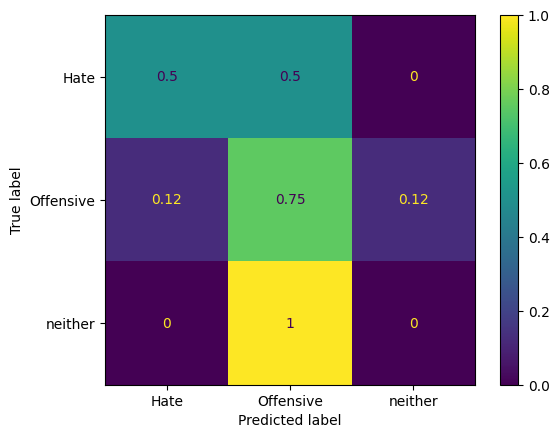

In [56]:
disp.plot()

In [43]:
cm.dtype

dtype('int64')